In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import pandas as pd
import numpy as np
import ast

#Data preperation

In [ ]:
"""
Load data
data.csv - the current jobs
ind_to_emb.csv - the embeddings of the industries
past.csv - the past jobs
"""
df = pd.read_csv('data.csv')
print(df.columns)
ind_to_emb_df = pd.read_csv('ind_to_emb.csv')
print(ind_to_emb_df.columns)
df_past = pd.read_csv('past.csv')
print(df_past.columns)

Index(['people_id', 'emb_est_courses', 'deg_feat', 'count_different_titles',
       'companies', 'company_id', 'industries', 'organization_type'],
      dtype='object')
Index(['industries', 'emb_est_industries'], dtype='object')
Index(['people_id', 'emb_est_courses', 'deg_feat', 'count_different_titles',
       'companies', 'company_id', 'industries', 'organization_type'],
      dtype='object')


In [ ]:
#embed industries from ind_to_emb
industry_embedding_map = dict(zip(ind_to_emb_df['industries'], ind_to_emb_df['emb_est_industries']))
for x in industry_embedding_map:
  y = industry_embedding_map[x]
  start = y.find("[")
  end = y.find("]") + 1   # +1 to include the last ]
  industry_embedding_map[x] = y[start:end]
#print(industry_embedding_map)

def get_embedding(industry):
    return industry_embedding_map.get(industry)


# Replace the 'industries' column in df with the embeddings from ind_to_emb.csv
df['industries'] = df['industries'].map(get_embedding)
df_past['industries'] = df_past['industries'].map(get_embedding)

# Display the updated dataframe
df.head()

,people_id,emb_est_courses,deg_feat,count_different_titles,companies,company_id,industries,organization_type
0,jasin-hiatt-335a5017,"[-0.574041, 0.89257103, -0.17844869, -0.304130...",0,10,...,73048085,"[-2.119343, 1.1766198, -1.3368629, -1.2402979,...",Educational
1,weiman-wu-2792b8161,"[-1.4302264, 1.3031118, -0.5052855, -0.7669209...",3,2,Barnes & Noble College,28332,"[-1.0413215, 1.2936286, -1.4789488, -1.9200661...",Public Company
2,steven-roberts-4b1778a6,"[-1.3632072, 1.0786605, -0.40744635, -0.350970...",3,9,Richmond Public Schools,8812329,"[-2.119343, 1.1766198, -1.3368629, -1.2402979,...",Educational
3,kavisha-sheth-805817244,"[-1.5193152, -0.19657813, 0.08053098, -1.72605...",0,3,DECA Inc.,1407425,"[-2.119343, 1.1766198, -1.3368629, -1.2402979,...",Nonprofit
4,franklibretto,"[-1.2257826, 1.1416869, -0.38558006, -0.678849...",2,10,"Meisinger Aviation, LLC",2656364,"[-0.07268268, 1.4661174, -1.5976624, -1.465338...",Privately Held


# == New imports ==

In [ ]:
#create df of people and embeding for each
past_jobs = df_past[['people_id', 'emb_est_courses', 'deg_feat', 'count_different_titles']]
past_jobs.rename(columns={'emb_est_courses': 'emb'}, inplace=True)

curr_jobs = df[['people_id','emb_est_courses', 'deg_feat', 'count_different_titles']]
curr_jobs.rename(columns={'emb_est_courses': 'emb'}, inplace=True)
people = pd.concat([past_jobs, curr_jobs])

<ipython-input-31-f6326e5b0dd4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_jobs.rename(columns={'emb_est_courses': 'emb'}, inplace=True)
<ipython-input-31-f6326e5b0dd4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_jobs.rename(columns={'emb_est_courses': 'emb'}, inplace=True)


In [ ]:
#create df of companies and embedding for each
curr_comp = df[['company_id','industries', 'organization_type']]
curr_comp.rename(columns={'industries': 'emb'}, inplace=True)

past_comp = df_past[['company_id','industries', 'organization_type']]
past_comp.rename(columns={'industries': 'emb'}, inplace=True)
comp = pd.concat([curr_comp, past_comp]).drop_duplicates(subset="company_id").reset_index(drop=True)

<ipython-input-33-64c5f32ea76b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_comp.rename(columns={'industries': 'emb'}, inplace=True)
<ipython-input-33-64c5f32ea76b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_comp.rename(columns={'industries': 'emb'}, inplace=True)


In [ ]:
# One-hot encode organiztion type
comp = pd.get_dummies(comp, columns=['organization_type'], prefix='organization_type')
# Convert only one-hot columns to integers
one_hot_columns = [col for col in comp.columns if col.startswith('organization_type_')]
comp[one_hot_columns] = comp[one_hot_columns].astype(int)

creating edges:

In [ ]:
curr_edge = df[['people_id','company_id']]
past_edge = df_past[['people_id','company_id']]

# Embedding

In [ ]:
# transform the list of embedding values to array type from string type
comp['emb'] = comp['emb'].apply(ast.literal_eval)
people['emb'] = people['emb'].apply(ast.literal_eval)

# Create a unique mapping of each people_id string to an integer
people_mapping = {id_str: idx for idx, id_str in enumerate(people['people_id'].unique())}
company_mapping = {id_str: idx for idx, id_str in enumerate(comp['company_id'].unique())}

In [ ]:
#apply mapping

#companies_nodes
comp['company_id'] = comp['company_id'].map(company_mapping)

#people_nodes
people['people_id'] = people['people_id'].map(people_mapping)

#past_edge
past_edge['people_id'] = past_edge['people_id'].map(people_mapping)
past_edge['company_id'] = past_edge['company_id'].map(company_mapping)

#curr_edge
curr_edge['people_id'] = curr_edge['people_id'].map(people_mapping)
curr_edge['company_id'] = curr_edge['company_id'].map(company_mapping)

<ipython-input-37-9911ad01560f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_edge['people_id'] = past_edge['people_id'].map(people_mapping)
<ipython-input-37-9911ad01560f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_edge['company_id'] = past_edge['company_id'].map(company_mapping)
<ipython-input-37-9911ad01560f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

# Transform Data to Tensors

In [ ]:
# Add padding to people df in order to have the same dimentions as companies
new_columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6']
people[new_columns] = 0

In [ ]:
# Convert `emb` from a column of arrays to a 2D array
emb_values = np.stack(comp['emb'].values)  # Ensures emb is a consistent 2D array
# Stack `emb_values` with `deg_feat` and `count_different_titles`
comp_features = np.hstack([
    emb_values,
    comp[['organization_type_Educational',
       'organization_type_Government Agency', 'organization_type_Nonprofit',
       'organization_type_Partnership', 'organization_type_Privately Held',
       'organization_type_Public Company', 'organization_type_Self-Employed',
       'organization_type_Self-Owned']].values
])
# Convert embeddings to a tensor for node features
x1 = torch.tensor(comp_features, dtype=torch.float)  # Node feature matrix
node_ids1 = torch.tensor(comp['company_id'].values, dtype=torch.long)     # Node IDs

# Convert `emb` from a column of arrays to a 2D array
emb_values = np.stack(people['emb'].values)  # Ensures emb is a consistent 2D array

# Stack `emb_values` with `deg_feat` and `count_different_titles`
people_features = np.hstack([
    emb_values,
    people[['deg_feat', 'count_different_titles', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6']].values
])

# Convert to a PyTorch tensor
x2 = torch.tensor(people_features, dtype=torch.float)
# Assuming your DataFrame is named df
node_ids2 = torch.tensor(people['people_id'].values, dtype=torch.long)


# Create node type tensors
node_types1 = torch.zeros(len(comp), dtype=torch.long)  # Type 'a' (companies) labeled as 0
node_types2 = torch.ones(len(people), dtype=torch.long)   # Type 'b' (people) labeled as 1

# Concatenate embeddings, IDs, and types
x = torch.cat([x1, x2], dim=0)               # Combined feature matrix
node_ids = torch.cat([node_ids1, node_ids2]) # Combined node IDs
node_types = torch.cat([node_types1, node_types2])  # Combined node types

In [ ]:
# create edges
past_edge_index = torch.tensor(past_edge[['people_id', 'company_id']].values.T, dtype=torch.long)  # Shape [2, num_edges]
curr_edge_index = torch.tensor(curr_edge[['people_id', 'company_id']].values.T, dtype=torch.long)  # Shape [2, num_edges]

In [ ]:
#remove duplicates
for i in range(curr_edge_index.shape[1]):
    # Get the current edge to remove from past_edge_index
    edge = curr_edge_index[:, i]

    # Step 2: Find the matching edge in past_edge_index
    mask = torch.all(past_edge_index == edge[:, None], dim=0)

    # Step 3: Remove the matching edge(s) from past_edge_index
    past_edge_index = past_edge_index[:, ~mask]

# Output the remaining edges in past_edge_index
print(past_edge_index)

tensor([[   0,    2,    4,  ..., 7137, 7138, 7139],
        [   0,    1,  455,  ..., 3135, 3135, 3135]])


In [ ]:
# Convert edge indices to tuples for easy comparison
past_edges = set(map(tuple, past_edge_index.t().tolist()))
curr_edges = set(map(tuple, curr_edge_index.t().tolist()))

# Find common and unique edges
common_edges = past_edges.intersection(curr_edges)
unique_past_edges = past_edges - common_edges
unique_curr_edges = curr_edges - common_edges

# Print results
print(f"Number of common edges: {len(common_edges)}")
print(f"Number of unique edges in past_edge_index: {len(unique_past_edges)}")
print(f"Number of unique edges in curr_edge_index: {len(unique_curr_edges)}")


Number of common edges: 0
Number of unique edges in past_edge_index: 8235
Number of unique edges in curr_edge_index: 882


In [ ]:
#data = Data(x=x, edge_index=past_edge_index, node_id=node_ids, node_type=node_types)
data = Data(x=x, edge_index=past_edge_index, node_id=node_ids)

# GNN Model


In [ ]:
#Define the GNN model
class JobPredictionGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(JobPredictionGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, int(hidden_channels*1.5))
        self.conv2 = SAGEConv(int(hidden_channels*1.5), hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu6(self.conv1(x, edge_index))
        x = F.relu6(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

    def predict_edges(self, x, edge_index_sample):
        src, dst = edge_index_sample
        embeddings_src, embeddings_dst = x[src], x[dst]
        edge_logits = (embeddings_src * embeddings_dst).sum(dim=-1)
        return torch.sigmoid(edge_logits)



model = JobPredictionGNN(in_channels=136, hidden_channels=64, out_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Function to create negative samples
def get_negative_samples(num_samples, num_nodes, curr_edge_set):
    negative_samples = []
    while len(negative_samples) < num_samples:
        src, dst = torch.randint(0, num_nodes, (2,))
        if (src.item(), dst.item()) not in curr_edge_set:
            negative_samples.append([src.item(), dst.item()])
    return torch.tensor(negative_samples).t()

# Custom accuracy function
def custom_accuracy(model, node_embeddings, curr_edge_index, neg_edge_index, thresh=0.5):
    # Predict probabilities for positive edges
    pos_edge_probs = model.predict_edges(node_embeddings, curr_edge_index)
    pos_predictions = (pos_edge_probs > thresh).float()  # Positive edge predictions based on threshold

    # Predict probabilities for negative edges
    neg_edge_probs = model.predict_edges(node_embeddings, neg_edge_index)
    neg_predictions = (neg_edge_probs > thresh).float()  # Negative edge predictions based on threshold

    # Calculate correct predictions for positive edges (True Positives)
    pos_correct = (pos_predictions == 1).sum().item()  # Predicted as edge exists where it actually does

    # Calculate correct predictions for negative edges (True Negatives)
    neg_correct = (neg_predictions == 0).sum().item()  # Predicted as no edge where it actually does not exist

    # Total number of edges (positive + negative)
    total_edges = curr_edge_index.size(1) + neg_edge_index.size(1)

    # Overall accuracy
    accuracy = (pos_correct + neg_correct) / total_edges
    return accuracy

def custom_f1_score(model, node_embeddings, curr_edge_index, neg_edge_index, thresh=0.5):
    # Predict probabilities for positive and negative edges
    pos_edge_probs = model.predict_edges(node_embeddings, curr_edge_index)
    neg_edge_probs = model.predict_edges(node_embeddings, neg_edge_index)

    # Get binary predictions based on threshold
    pos_predictions = (pos_edge_probs > thresh).float()  # Positive edge predictions
    neg_predictions = (neg_edge_probs > thresh).float()  # Negative edge predictions

    # True Positives: correctly predicted positive edges
    true_positives = (pos_predictions == 1).sum().item()

    # False Positives: predicted positive where there is no edge
    false_positives = (neg_predictions == 1).sum().item()

    # False Negatives: predicted negative where there is an edge
    false_negatives = (pos_predictions == 0).sum().item()

    # Calculate precision, recall, and F1 score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1_score

def f1_score(model, node_embeddings, curr_edge_index, thresh=0.5):
    # Predict probabilities for positive edges
    pos_edge_probs = model.predict_edges(node_embeddings, curr_edge_index)

    # Get binary predictions based on threshold for positive edges
    pos_predictions = (pos_edge_probs > thresh).float()

    # True Positives: correctly predicted positive edges
    true_positives = (pos_predictions == 1).sum().item()

    # False Negatives: predicted negative where there is an edge
    false_negatives = (pos_predictions == 0).sum().item()

    # Calculate precision, recall, and F1 score
    precision = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1


graph = data

# Training loop with custom accuracy and negative sampling
accs = []
epocs = []
f1_scores = []
f1_custom_scores = []
num_epochs = 100
max_acc = 0
for epoch in range(num_epochs):
    epocs.append(epoch)
    model.train()
    optimizer.zero_grad()

    # Forward pass
    node_embeddings = model(graph.x, graph.edge_index)

    # Prepare positive and negative samples
    pos_edge_labels = torch.ones(curr_edge_index.size(1))  # Positive edges
    curr_edges_set = set(map(tuple, curr_edge_index.t().tolist()))
    neg_edge_index = get_negative_samples(curr_edge_index.size(1), graph.num_nodes, curr_edges_set)
    neg_edge_labels = torch.zeros(neg_edge_index.size(1))  # Negative edges

    # Combine positive and negative edges
    all_edges = torch.cat([curr_edge_index, neg_edge_index], dim=1)
    all_labels = torch.cat([pos_edge_labels, neg_edge_labels])

    # Predict and calculate balanced loss
    edge_probs = model.predict_edges(node_embeddings, all_edges)
    loss = F.binary_cross_entropy(edge_probs, all_labels)
    loss.backward()
    optimizer.step()

    # Calculate custom accuracy
    if (epoch ) % 1 == 0:  # Evaluate every 10 epochs
        model.eval()
        with torch.no_grad():
          neg_edge_index = get_negative_samples(graph.num_edge_types, graph.num_nodes, set(map(tuple, past_edge_index.t().tolist())))

          # Calculate accuracy and F1 score based on the updated node embeddings
          accuracy = custom_accuracy(model, node_embeddings, curr_edge_index, neg_edge_index, thresh=0.7)
          custom_f1 = custom_f1_score(model, node_embeddings, curr_edge_index, neg_edge_index, thresh=0.7)
          f1 = f1_score(model, node_embeddings, curr_edge_index, thresh=0.7)


          # Track maximum accuracy
          max_acc = max(max_acc, accuracy)
          accs.append(accuracy)
          f1_scores.append(f1)
          f1_custom_scores.append(custom_f1)

          # Print performance metrics
          print(f"Test Results - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, custom F1 score: {custom_f1:.4f}")

print(f"Max Accuracy: {max_acc:.4f}")

Test Results - Accuracy: 0.1665, F1 Score: 0.1655, custom F1 score: 0.2840
Test Results - Accuracy: 0.1518, F1 Score: 0.1508, custom F1 score: 0.2621
Test Results - Accuracy: 0.2333, F1 Score: 0.2324, custom F1 score: 0.3772
Test Results - Accuracy: 0.5210, F1 Score: 0.5204, custom F1 score: 0.6846
Test Results - Accuracy: 0.2888, F1 Score: 0.2880, custom F1 score: 0.4472
Test Results - Accuracy: 0.2276, F1 Score: 0.2268, custom F1 score: 0.3697
Test Results - Accuracy: 0.4858, F1 Score: 0.4853, custom F1 score: 0.6534
Test Results - Accuracy: 0.6308, F1 Score: 0.6304, custom F1 score: 0.7733
Test Results - Accuracy: 0.5810, F1 Score: 0.5805, custom F1 score: 0.7346
Test Results - Accuracy: 0.4689, F1 Score: 0.4683, custom F1 score: 0.6378
Test Results - Accuracy: 0.4202, F1 Score: 0.4195, custom F1 score: 0.5911
Test Results - Accuracy: 0.4541, F1 Score: 0.4535, custom F1 score: 0.6240
Test Results - Accuracy: 0.5572, F1 Score: 0.5567, custom F1 score: 0.7152
Test Results - Accuracy: 

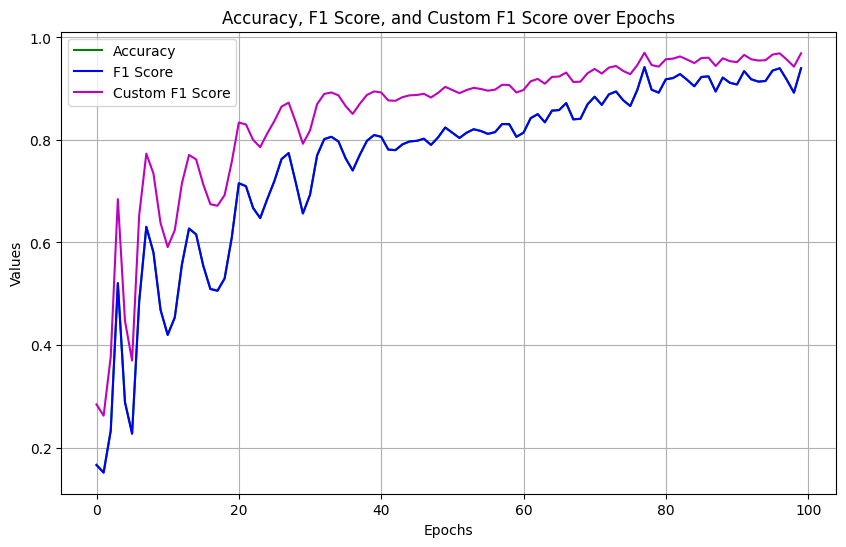

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epocs, accs, label="Accuracy", color="green")
plt.plot(f1_scores, label='F1 Score', color='b')
plt.plot(f1_custom_scores, label='Custom F1 Score', color='m')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title('Accuracy, F1 Score, and Custom F1 Score over Epochs')
plt.legend()
plt.grid(True)
plt.show()


**Potential more complicated model**

note: we didnt get better results

In [ ]:
# class JobPredictionGNN(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super(JobPredictionGNN, self).__init__()
#         self.conv1 = SAGEConv(in_channels, int(hidden_channels*1.5), normalize=True)
#         self.conv2 = SAGEConv(int(hidden_channels*1.5), hidden_channels, normalize=True)
#         self.conv3 = SAGEConv(hidden_channels, out_channels, normalize=True)

#         self.dropout = 0.3
#         self.batch_norm1 = torch.nn.BatchNorm1d(int(hidden_channels*1.5))
#         self.batch_norm2 = torch.nn.BatchNorm1d(hidden_channels)

#         # Linear layers to match dimensions for residual connection at each layer
#         self.residual_projection1 = torch.nn.Linear(in_channels, int(hidden_channels*1.5))
#         self.residual_projection2 = torch.nn.Linear(int(hidden_channels*1.5), hidden_channels)

#     def forward(self, x, edge_index):
#         # First layer residual
#         residual = self.residual_projection1(x)  # Project residual to match conv1 output shape

#         # First convolution
#         x = self.conv1(x, edge_index)
#         x = F.sigmoid(self.batch_norm1(x))
#         x = F.dropout(x, p=self.dropout, training=self.training)
#         x = x + residual  # Adding residual with matching shape

#         # Second layer residual
#         residual = self.residual_projection2(x)  # Project residual to match conv2 output shape

#         # Second convolution
#         x = self.conv2(x, edge_index)
#         x = F.relu6(self.batch_norm2(x))
#         x = F.dropout(x, p=self.dropout, training=self.training)
#         x = x + residual  # Adding residual with matching shape

#         # Output layer (no residuals after this layer)
#         x = self.conv3(x, edge_index)

#         return x
#     def predict_edges(self, x, edge_index_sample):
#         src, dst = edge_index_sample
#         embeddings_src, embeddings_dst = x[src], x[dst]
#         edge_logits = (embeddings_src * embeddings_dst).sum(dim=-1)
#         return torch.sigmoid(edge_logits)